# Project MSB1015 Scientific Programming

### Author: Julia Streutker

### Topic: Edible & poisonous mushrooms

### Research Question(s): 

#### Initially: What ML algorithms would be most accurate in determining edibility of the mushrooms?

#### Final: Which feature would be good to use for identifying edible mushrooms by non-trained people?

### Sub research question: 

#### Initially: Which feature would be good to use for identifying edible mushrooms by non-trained people?

#### Final: Removed

(For the sub research question it was finally intended to the initial main research question, however, due to time constrains I was unable to incoporate other ML models, therefore, it was removed.)

### Set up:

To start the project (and code) the necessary libraries were installed and/or imported, and the mushroom data set was fetched. To check if the data set was correctly imported, the first 5 rows were printed with expected 23 columns.

In [13]:
# Necessary installs
!pip3 install -U ucimlrepo 
!pip3 install scipy

# Importing necessary basic libraries
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np 
import sklearn 
import math

# Importing libraries for visualisation
import matplotlib.pyplot as plt # To plot figures
import seaborn as sns # To create figures
import warnings
warnings.filterwarnings('ignore') # This will stop warnings from being printed

# Importing libraries necessary for running the model(s)
from sklearn.model_selection import train_test_split, cross_val_score # Creating training and test data set & the accuracy measurement of the cv folds
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score # Used as the accuracy measurement of the model
from sklearn.manifold import MDS # Used to perform PCoA
from scipy.stats import pearsonr # Used to measure how similar two models perceive the structure of the data
from sklearn.preprocessing import OneHotEncoder # For encoding the features
from sklearn.preprocessing import LabelEncoder # For encoding the targets

# Model(s)
from sklearn.ensemble import RandomForestClassifier

In [14]:
# Fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# The data as pandas dataframes 
mushroom_features = mushroom.data.features 
mushroom_targets = mushroom.data.targets 

# Combine features and targets into one DataFrame
mushroom_df = pd.concat([mushroom_features, mushroom_targets], axis=1)

# Inspect the dataframe if it imported correctly
mushroom_df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


### Data exploration part 1:

To better understand the data worked on, various aspects were studied: the metadata and variables for missing values, outliers, target (labels) distribution, dublicates, and labeling errors.

In [15]:
# Metadata 
print(mushroom.metadata) 
  
# Variable information 
print(mushroom.variables) 

# Duplication check
print('Number of dublicate instances:', mushroom_df.duplicated().sum())

# To find the total number of missing values, after mMissing values were seen in the output of variable information 
print('Number of missing values:\n', mushroom_df.isnull().sum())

{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

In [16]:
# Checking how many categories are in each feature and how many in total
for col in mushroom_features.columns:
    print(col, mushroom_features[col].nunique())

total_categories = sum(mushroom_features[col].nunique() for col in mushroom_features.columns)
print("Total categories:", total_categories)

cap-shape 6
cap-surface 4
cap-color 10
bruises 2
odor 9
gill-attachment 2
gill-spacing 2
gill-size 2
gill-color 12
stalk-shape 2
stalk-root 4
stalk-surface-above-ring 4
stalk-surface-below-ring 4
stalk-color-above-ring 9
stalk-color-below-ring 9
veil-type 1
veil-color 4
ring-number 3
ring-type 5
spore-print-color 9
population 6
habitat 7
Total categories: 116


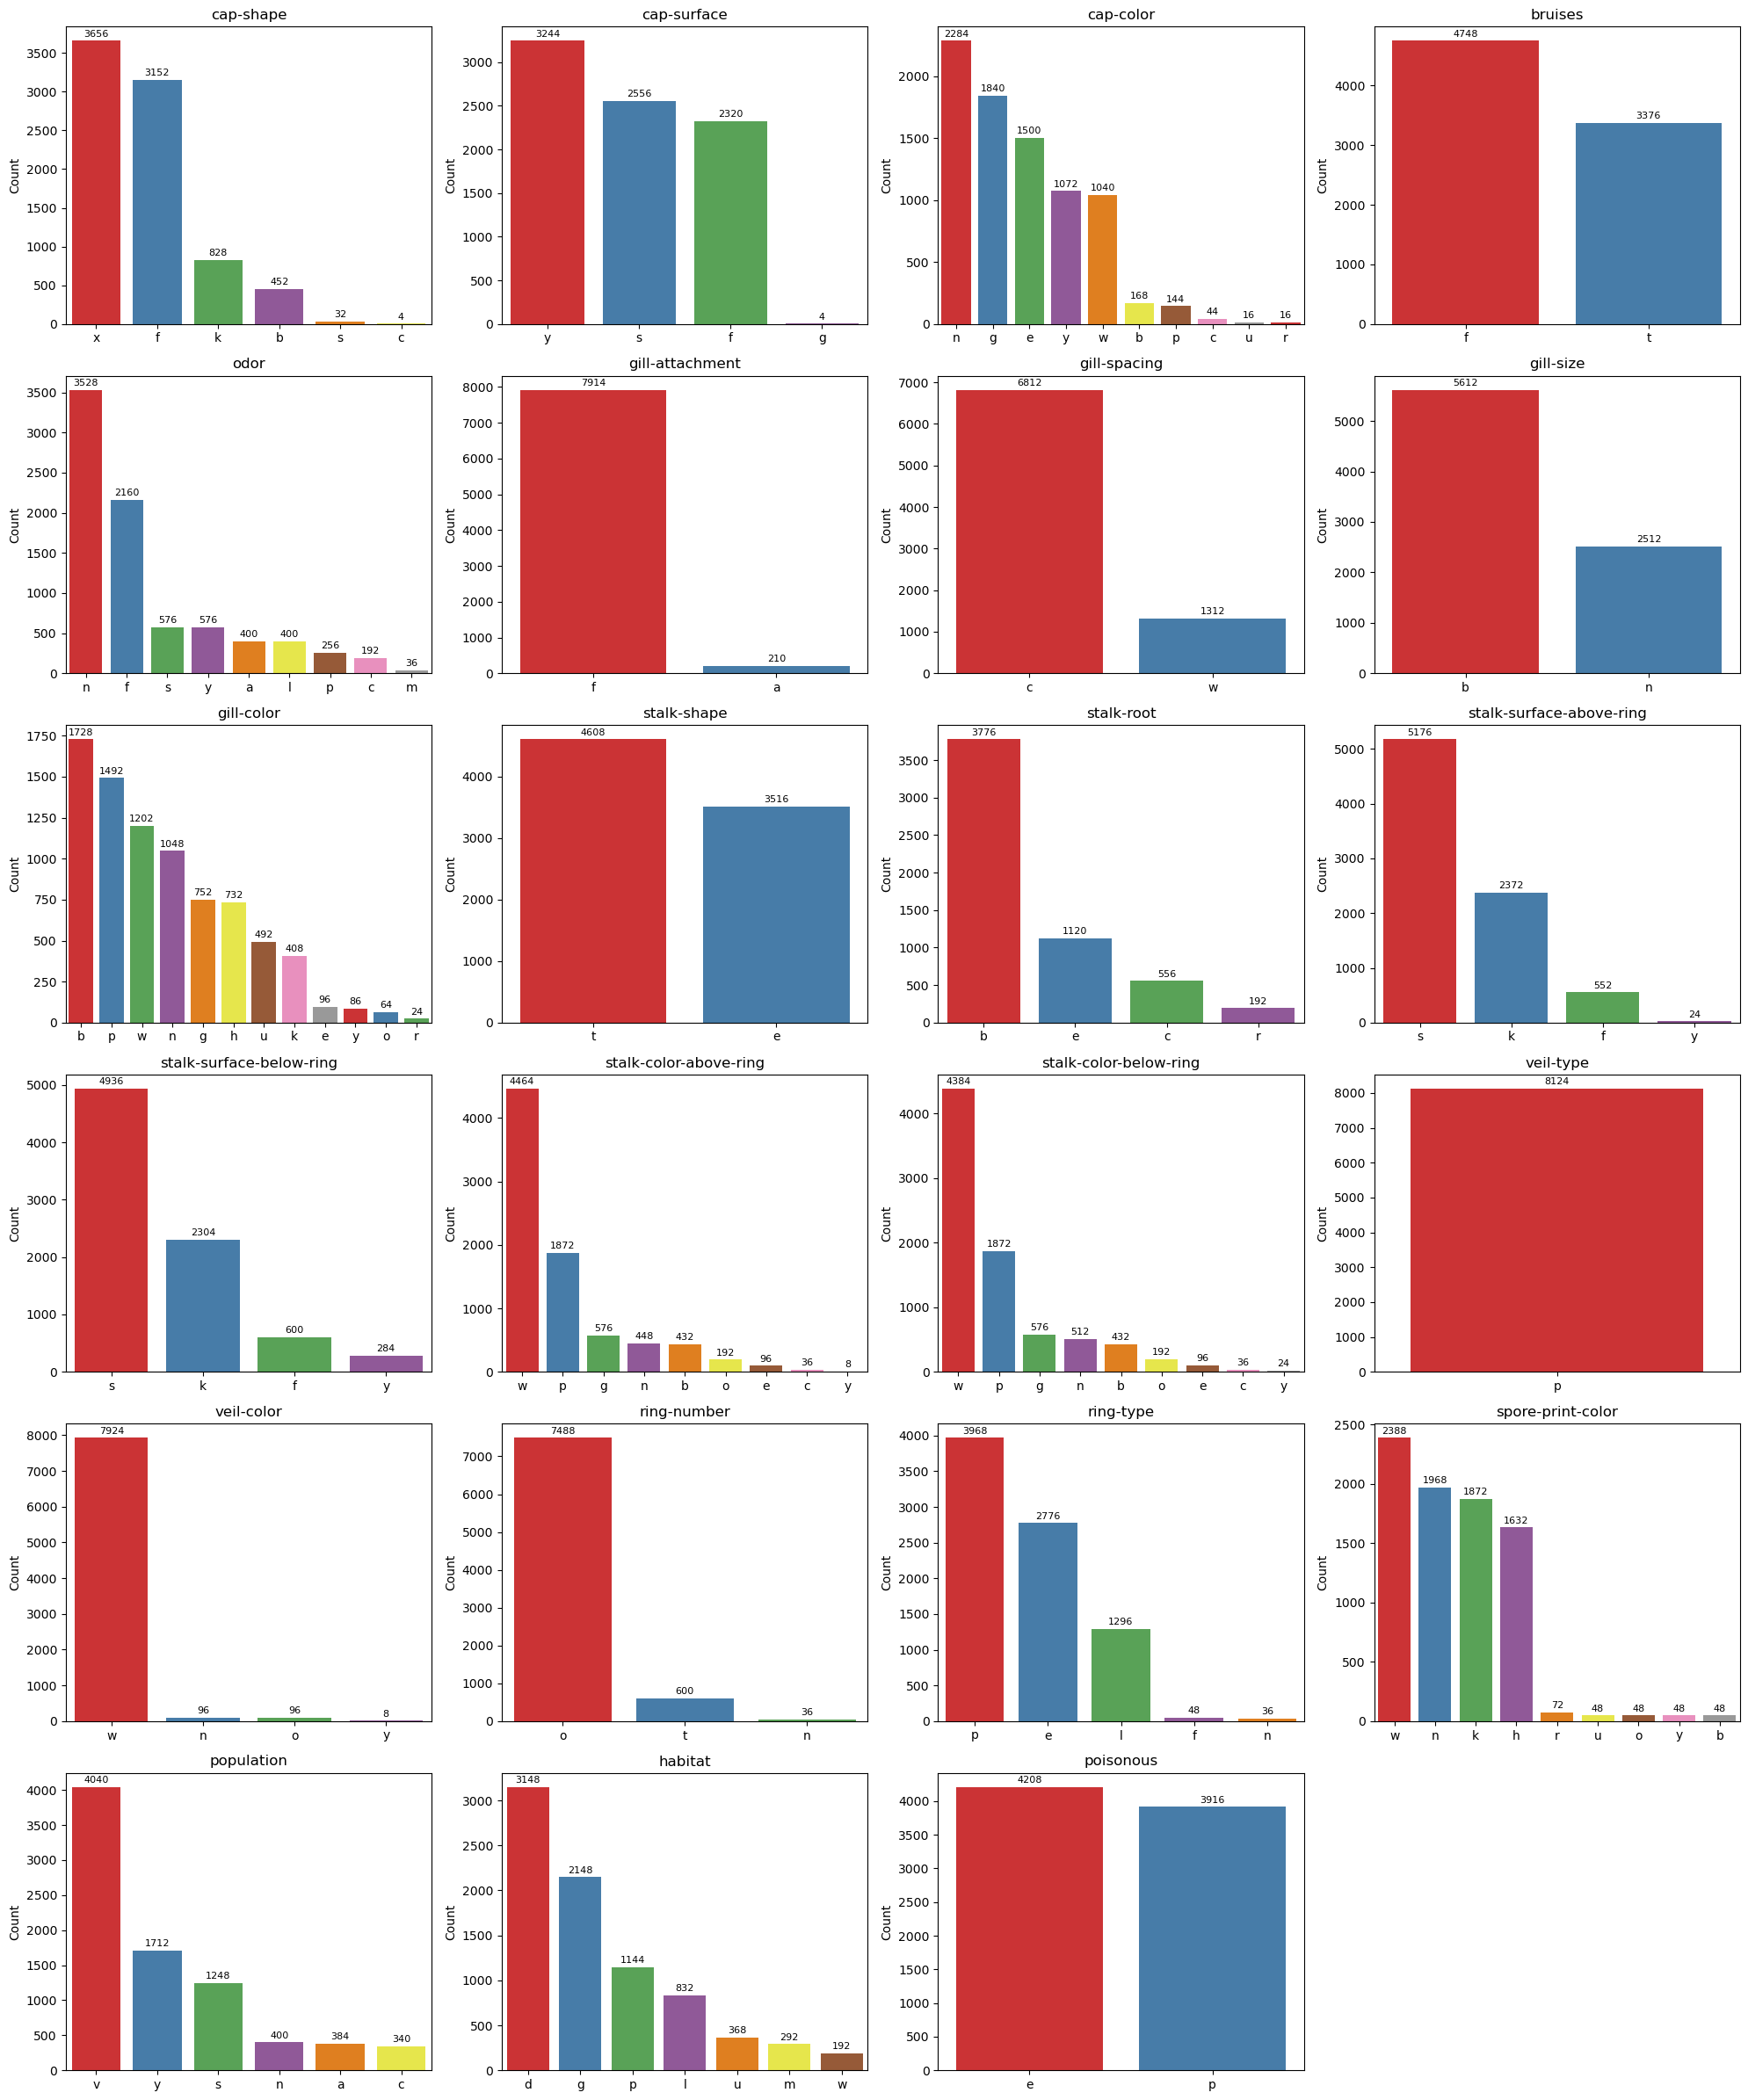

In [17]:
# Create list with all the features of the training data
mushroom_feat_tar_list = list(mushroom_df.columns)

# Number of features
n_features = len(mushroom_feat_tar_list)

# Setting grid size
n_cols = 4
n_rows = math.ceil(n_features / n_cols)

# Create the grid & determine it's size
fig, axes = plt.subplots(n_rows, n_cols, figsize = (n_cols*5, n_rows*4)) 

# For loop running through all the features in the mushroom_feat_tar_list to make seperate barplots
for i, c in enumerate(mushroom_feat_tar_list):
    row = i // n_cols   # Finding current row
    col = i % n_cols    # Finding current column
    ax = axes[row, col]
    sns.countplot(
        x = c, 
        data = mushroom_df, 
        palette = "Set1", 
        order = mushroom_df[c].value_counts().index,
        ax = ax)
    
    # Add counts on top of the individual bars
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center', va = 'bottom', fontsize = 8, color = 'black', xytext = (0, 2), textcoords = 'offset points')
 
    ax.set_title(f'{c}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x')

# Remove empty subplots if n_features doesn’t fill the grid
for j in range(i+1, n_rows*n_cols):
    row = j // n_cols   
    col = j % n_cols    
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()   

Looking at the above outputs, we can see that:
- There are missing values only in the 11 feature (stalk root), these missing values will need to be imputed or otherwise dealt with, for their numbers are significant (2480)!
- All instances have the same veil-type, therefor, this feature can be removed
- The distribution between poisinous and edible mushrooms is close to 50/50, this means there is no class imbalance (which is good!)
- Some features have lower instances for some categories, but with the counts on top of the bars you can see that there are always a few counts of these categories, and with all the options being mentioned in the meta data, we can conclude they are unlikely to be errors
- There are 0 duplicate instances, which might seem unlikely in a data set of 8124 instances, but the UCI Mushroom data set was curated, and therefore duplicates were most likely removed.

### Data preprocessing:

From the previous data exploration section we can now prepare the data for later use. To start of with removing the unnecessary feature veil_type and dealing with the missing values in the stalk_root feature. There were mulitple options discussed but, due to time constrains and the amount of missig values, the simplist method was employed. This meant removing the feature stalk_root. Various algorithms are unable to work with categorical data if it is expressed in string, therefore, the data was encoded using OneHotEncoder for features, since it can work with different categorical data, and LabelEncoder for the targets, since it works well for binary categorical data. The data was also spil into a training and test set.

In [18]:
# Data preperation
# Removing the feature veil-type
mushroom_features = mushroom_features.drop(['veil-type'], axis = 1)

# Recreate the combined features (X) and targets (y) DataFrame, now without the removed veil-type feature
mushroom_df = pd.concat([mushroom_features, mushroom_targets], axis=1)

# Inspect the dataframe if it imported correctly
print(mushroom_df.shape)

# Missing values dealing options: start with option 1, if time allows will start implementing and running the other options one-by-one
# 1. Removing the feature stalk-root, for of the 8124 instances 2480 (~30%) have missing stalk-root input. 
# This is very significant so removing the feature could be a good method to deal with this issue, even though this would cost potential information
# Removing the feature stalk-root
mushroom_features = mushroom_features.drop(['stalk-root'], axis = 1)

# Recreate the combined features (X) and targets (y) DataFrame, now without the removed veil-type feature
mushroom_df = pd.concat([mushroom_features, mushroom_targets], axis=1)

# Inspect the dataframe if it imported correctly
print(mushroom_df.shape)

# 2. Imputing the missing values at random. This preserves the distribution, but adds randomness.

# 3. Treat the missing values as a category in this feature. Keeps any information contained in the feature stalk-root,
# but this could lead to the model assuming missing is information, and this would influence the models decision on the target prediction.

# 4. Impute using related features. Is more computational heavy and has the risk of overfitting, but it is more accurate then randomly imputing.

# Checking how many categories in total after feature removal
total_categories = sum(mushroom_features[col].nunique() for col in mushroom_features.columns)
print("Total categories:", total_categories)

(8124, 22)
(8124, 21)
Total categories: 111


In [19]:
# Preparation for training the models
# Preparing the encoders
encoder = OneHotEncoder()
label_encoder = LabelEncoder()

# Encoding the data so that different models can work with the categorical data
m_features_encoded = encoder.fit_transform(mushroom_features) # OneHotEncoder for the features (it can deal with different type of categorical data
m_targets_encoded = label_encoder.fit_transform(mushroom_targets) # LabelEncoder for the targets, if deals with binary data. Here 0 is edible and 1 is Poisonous

# To see which target category got which label (Output will show that 'e'dible was assigned 0 and 'p'oisonous was assigned 1)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

# Convert to DataFrame with proper column names
m_features_encoded_df = pd.DataFrame(
    m_features_encoded.toarray(),
    columns=encoder.get_feature_names_out(mushroom_features.columns))

# Separate the mushroom data set into training and testing data sets
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    m_features_encoded_df , m_targets_encoded, test_size = 0.20, random_state = 0) # Split is done 80% training set and 20% test set. A random state was given to always get the same random split.

{'e': np.int64(0), 'p': np.int64(1)}


### Data exploration part 2:
Below code to be able to run PCoA, using that to also check if there is data leakage or other issues.

Instead of using just the Gower distance to run PCoA (This is simpler, but it won’t capture the same complex relationships that the unsupervised RF proximity might capture (like interactions between features)), and instead I run a unsupervised RF on real and synthetic data and use it's proximitry distance as a measure.

Subset size: (1000, 111)
Training unsupervised Random Forest...
Building unsupervised proximity matrix...
Performing PCoA (unsupervised)...


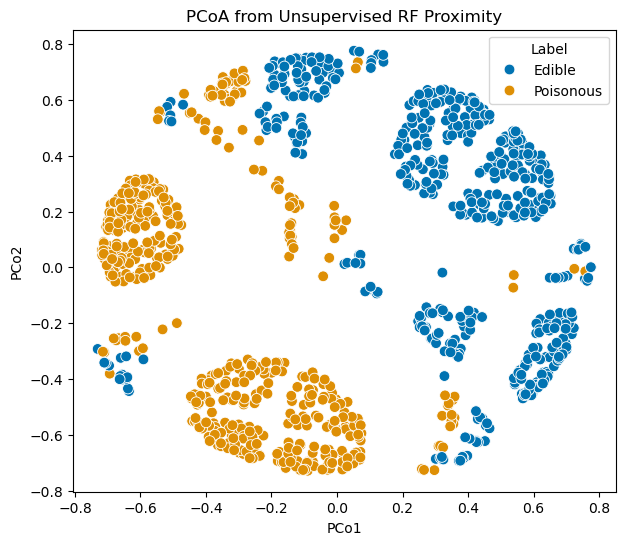

Training supervised Random Forest...
Comparing proximities...

Correlation between unsupervised and supervised proximities:
Pearson r = 0.891, p ≈ 0.000e+00
Building side-by-side comparison plots...


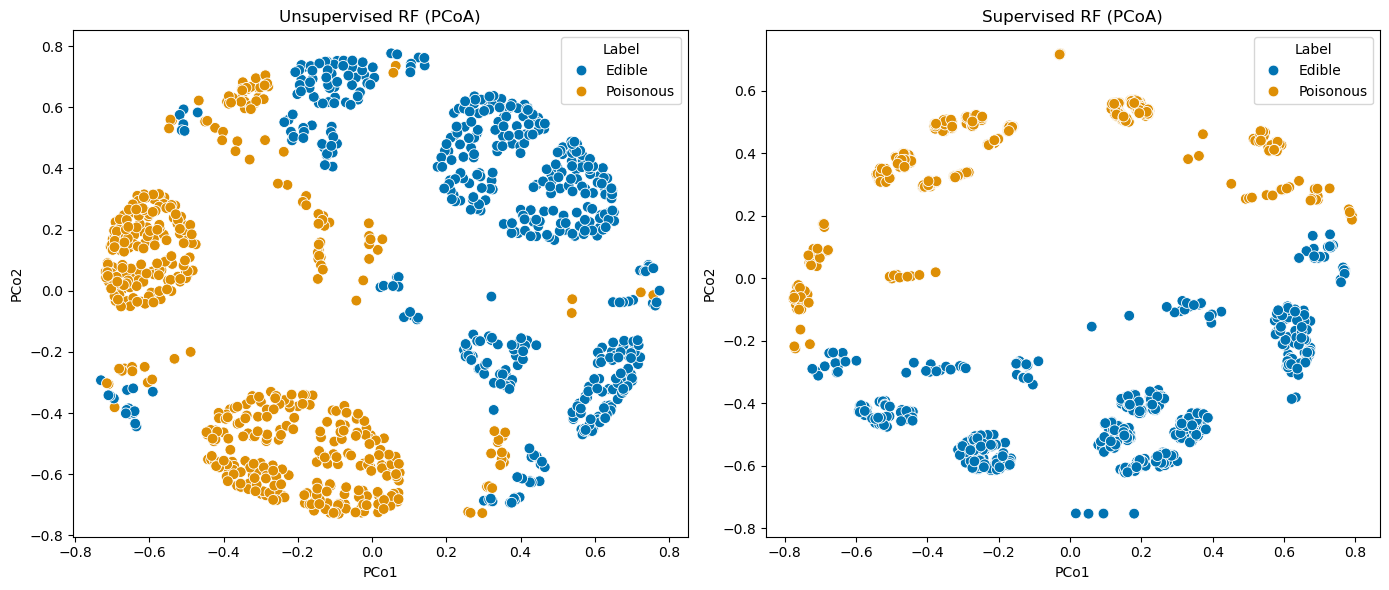

Repeating Unsupervised and Supervised runs ...

=== Run 1/3 (random_state=0) ===
Pearson r = 0.891

=== Run 2/3 (random_state=1) ===
Pearson r = 0.882

=== Run 3/3 (random_state=2) ===
Pearson r = 0.887

=== Summary over runs ===
Mean Pearson r: 0.887
Std. dev. of r: 0.004


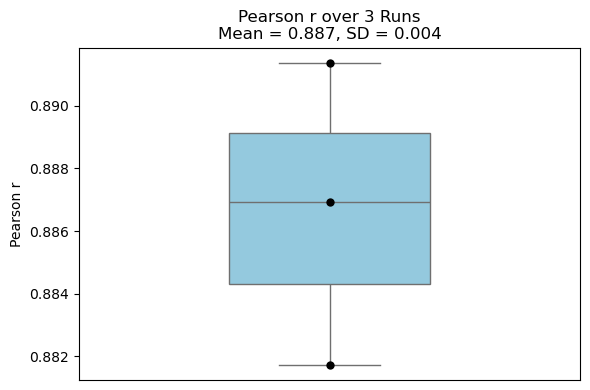

Building Supervised vs. Unsupervised distance correlation plot...


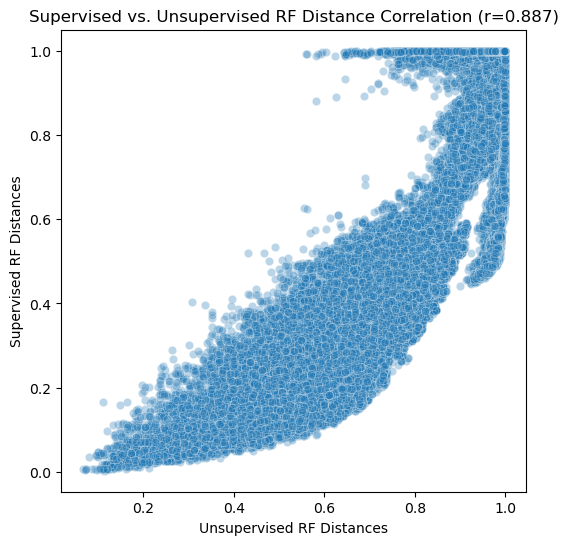

In [20]:
# Load and prepare the dataset
# m_features_encoded_df  -> encoded features (DataFrame)
# m_targets_encoded      -> encoded labels (0=edible, 1=poisonous)

# Subset to make it run faster
# Setting the random choice to a specific seed
rng = np.random.default_rng(seed=0)
subset_idx = rng.choice(m_features_encoded_df.index, size=1000, replace=False) # PUT A SEED!!!
X_sub = m_features_encoded_df.loc[subset_idx].reset_index(drop=True)
y_sub = pd.Series(m_targets_encoded[subset_idx]).reset_index(drop=True)

# Convert y_sub to categorical labels (had issues with labels not sticking, so had to do this)
y_labels = pd.Series(y_sub).map({0: "Edible", 1: "Poisonous"}).astype("category")
y_labels.name = "Label"
print("Subset size:", X_sub.shape)

# Unsupervised Random Forest training
print("Training unsupervised Random Forest...") # Liked this in the output, put it in more section, that way I will know if it is running properly

# Generate synthetic (randomized) data
synthetic = X_sub.apply(np.random.permutation)
synthetic['label'] = 0
real = X_sub.copy()
real['label'] = 1

combined = pd.concat([real, synthetic], axis=0).reset_index(drop=True)
y_unsup = combined['label']
X_unsup = combined.drop(columns='label')

rf_unsup = RandomForestClassifier(
    n_estimators=1000,
    max_features='sqrt',
    n_jobs=-1,
    random_state=0
)
rf_unsup.fit(X_unsup, y_unsup)

# Compute proximity matrix (unsupervised)
print("Building unsupervised proximity matrix...")
leaves_unsup = rf_unsup.apply(X_sub)
n_samples, n_trees = leaves_unsup.shape
prox_unsup = np.zeros((n_samples, n_samples))

for t in range(n_trees):
    leaf_ids = leaves_unsup[:, t]
    for leaf in np.unique(leaf_ids):
        idx = np.where(leaf_ids == leaf)[0]
        prox_unsup[np.ix_(idx, idx)] += 1

prox_unsup /= n_trees
dist_unsup = 1 - prox_unsup

# PCoA (using MDS) on Unsupervised RF proximity
print("Performing PCoA (unsupervised)...")
pcoa_unsup = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
X_pcoa_unsup = pcoa_unsup.fit_transform(dist_unsup)

plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_pcoa_unsup[:,0], y=X_pcoa_unsup[:,1],
    hue=y_labels, palette="colorblind", s=60
)
plt.title("PCoA from Unsupervised RF Proximity")
plt.xlabel("PCo1")
plt.ylabel("PCo2")
plt.show()

# Supervised Random Forest training (baseline)
print("Training supervised Random Forest...")
rf_sup = RandomForestClassifier(
    n_estimators=1000,
    max_features='sqrt',
    n_jobs=-1,
    random_state=0
)
rf_sup.fit(X_sub, y_sub)

leaves_sup = rf_sup.apply(X_sub)
prox_sup = np.zeros((n_samples, n_samples))

for t in range(n_trees):
    leaf_ids = leaves_sup[:, t]
    for leaf in np.unique(leaf_ids):
        idx = np.where(leaf_ids == leaf)[0]
        prox_sup[np.ix_(idx, idx)] += 1

prox_sup /= n_trees
dist_sup = 1 - prox_sup

# PCoA (using MDS) on Supervised RF proximity
pcoa_sup = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
X_pcoa_sup = pcoa_sup.fit_transform(dist_sup)

# Compare unsupervised vs supervised proximities
print("Comparing proximities...")

def flatten_upper(mat):
    idx = np.triu_indices_from(mat, k=1)
    return mat[idx]

r, p = pearsonr(flatten_upper(dist_unsup), flatten_upper(dist_sup))
print(f"\nCorrelation between unsupervised and supervised proximities:")
print(f"Pearson r = {r:.3f}, p ≈ {p:.3e}")

# Visual comparison (side-by-side PCoA)
print("Building side-by-side comparison plots...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=X_pcoa_unsup[:,0], y=X_pcoa_unsup[:,1],
                hue=y_labels, palette="colorblind", s=60, ax=axes[0])
axes[0].set_title("Unsupervised RF (PCoA)")
axes[0].set_xlabel("PCo1")
axes[0].set_ylabel("PCo2")

sns.scatterplot(x=X_pcoa_sup[:,0], y=X_pcoa_sup[:,1],
                hue=y_labels, palette="colorblind", s=60, ax=axes[1])
axes[1].set_title("Supervised RF (PCoA)")
axes[1].set_xlabel("PCo1")
axes[1].set_ylabel("PCo2")

plt.tight_layout()
plt.show()

# Repeat runs to test stability of correlation (mean & std)
print("Repeating Unsupervised and Supervised runs ...")
n_runs = 3
r_values = []

for seed in range(n_runs):
    print(f"\n=== Run {seed+1}/{n_runs} (random_state={seed}) ===")

    # Unsupervised RF
    rf_unsup = RandomForestClassifier(
        n_estimators=1000,
        max_features='sqrt',
        n_jobs=-1,
        random_state=seed
    )
    rf_unsup.fit(X_unsup, y_unsup)

    leaves_unsup = rf_unsup.apply(X_sub)
    n_samples, n_trees = leaves_unsup.shape
    prox_unsup = np.zeros((n_samples, n_samples))
    for t in range(n_trees):
        leaf_ids = leaves_unsup[:, t]
        for leaf in np.unique(leaf_ids):
            idx = np.where(leaf_ids == leaf)[0]
            prox_unsup[np.ix_(idx, idx)] += 1
    prox_unsup /= n_trees
    dist_unsup = 1 - prox_unsup

    # Supervised RF
    rf_sup = RandomForestClassifier(
        n_estimators=1000,
        max_features='sqrt',
        n_jobs=-1,
        random_state=seed
    )
    rf_sup.fit(X_sub, y_sub)

    leaves_sup = rf_sup.apply(X_sub)
    prox_sup = np.zeros((n_samples, n_samples))
    for t in range(n_trees):
        leaf_ids = leaves_sup[:, t]
        for leaf in np.unique(leaf_ids):
            idx = np.where(leaf_ids == leaf)[0]
            prox_sup[np.ix_(idx, idx)] += 1
    prox_sup /= n_trees
    dist_sup = 1 - prox_sup

    # Compare the two proximity matrices
    idx = np.triu_indices_from(dist_unsup, k=1)
    r, _ = pearsonr(dist_unsup[idx], dist_sup[idx])
    print(f"Pearson r = {r:.3f}")
    r_values.append(r)

# After all runs
print("\n=== Summary over runs ===")
print(f"Mean Pearson r: {np.mean(r_values):.3f}")
print(f"Std. dev. of r: {np.std(r_values):.3f}")

# Boxplot of Pearson r values over runs 
plt.figure(figsize=(6, 4))
sns.boxplot(data=r_values, color="skyblue", width=0.4)
sns.stripplot(data=r_values, color="black", size=6, jitter=False)

mean_r = np.mean(r_values)
std_r = np.std(r_values)

plt.title(f"Pearson r over {n_runs} Runs\nMean = {mean_r:.3f}, SD = {std_r:.3f}")
plt.ylabel("Pearson r")
plt.xticks([])
plt.tight_layout()
plt.show()

# Visualize Supervised vs. Unsupervised distance correlation
print("Building Supervised vs. Unsupervised distance correlation plot...")

plt.figure(figsize=(6,6))
sns.scatterplot(x=flatten_upper(dist_unsup), y=flatten_upper(dist_sup), alpha=0.3)
plt.xlabel("Unsupervised RF Distances")
plt.ylabel("Supervised RF Distances")
plt.title(f"Supervised vs. Unsupervised RF Distance Correlation (r={r:.3f})")
plt.show()

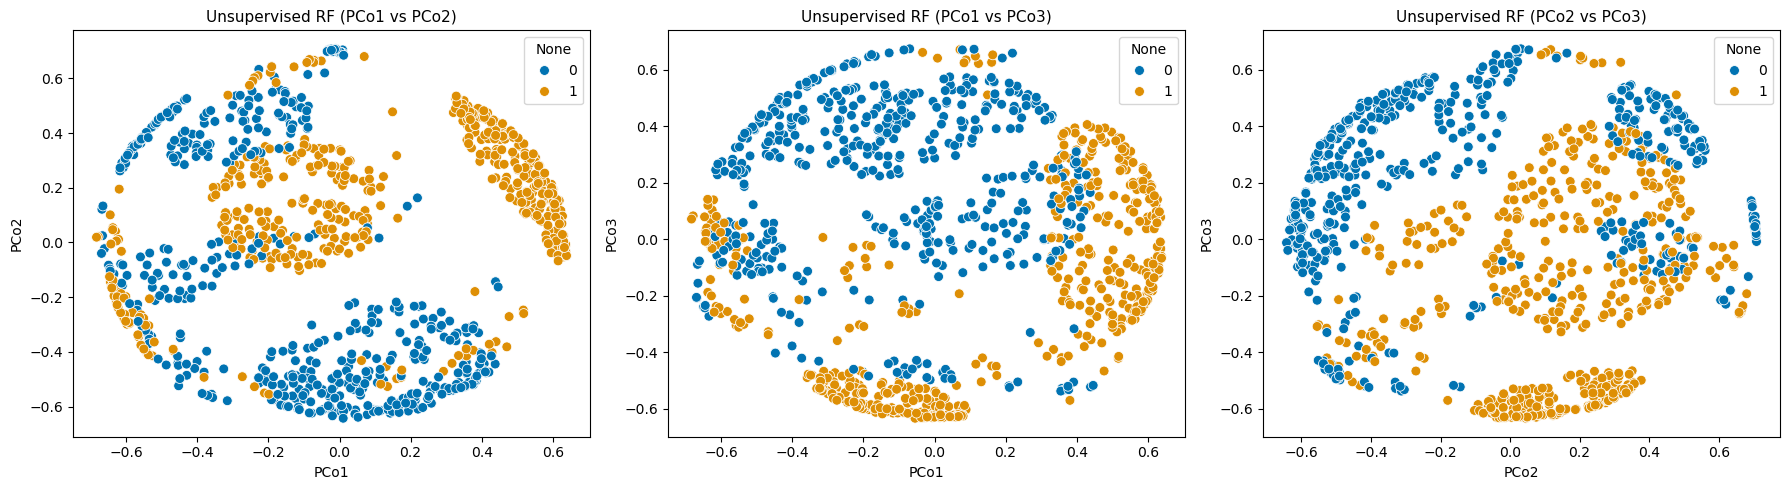

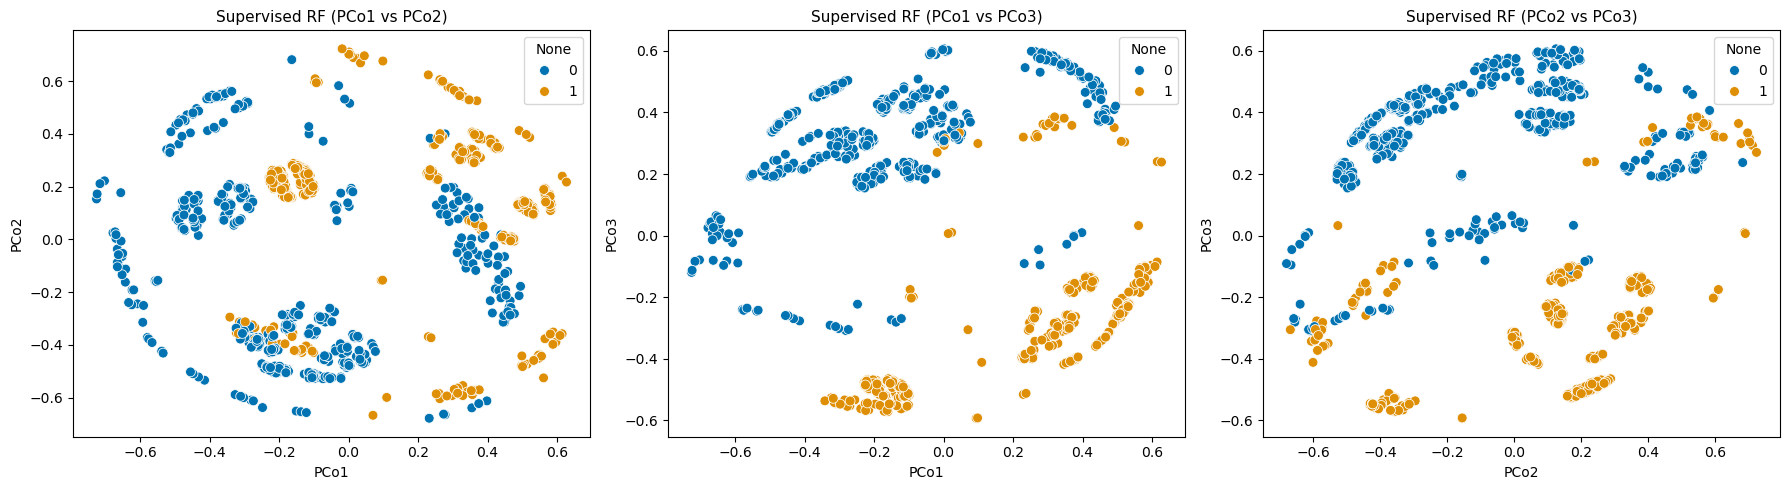

In [21]:
# Now to try and look at more PCo's than just the first 2
# Unsupervised PCoA 3D
pcoa_unsup_3D = MDS(n_components=3, dissimilarity="precomputed", random_state=0)
X_pcoa_unsup_3D = pcoa_unsup_3D.fit_transform(dist_unsup)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
pairs = [(0,1), (0,2), (1,2)]
titles = ["PCo1 vs PCo2", "PCo1 vs PCo3", "PCo2 vs PCo3"]

for ax, (x_idx, y_idx), title in zip(axes, pairs, titles):
    sns.scatterplot(
        x=X_pcoa_unsup_3D[:, x_idx],
        y=X_pcoa_unsup_3D[:, y_idx],
        hue=y_sub,
        palette="colorblind",
        s=50,
        ax=ax
    )
    ax.set_title(f"Unsupervised RF ({title})", fontsize=11)
    ax.set_xlabel(f"PCo{x_idx+1}")
    ax.set_ylabel(f"PCo{y_idx+1}")

plt.tight_layout()
plt.show()

# Supervised PCoA 3D 
pcoa_sup_3D = MDS(n_components=3, dissimilarity="precomputed", random_state=0)
X_pcoa_sup_3D = pcoa_sup_3D.fit_transform(dist_sup)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (x_idx, y_idx), title in zip(axes, pairs, titles):
    sns.scatterplot(
        x=X_pcoa_sup_3D[:, x_idx],
        y=X_pcoa_sup_3D[:, y_idx],
        hue=y_sub,
        palette="colorblind",
        s=50,
        ax=ax
    )
    ax.set_title(f"Supervised RF ({title})", fontsize=11)
    ax.set_xlabel(f"PCo{x_idx+1}")
    ax.set_ylabel(f"PCo{y_idx+1}")

plt.tight_layout()
plt.show()

Accuracy scores for model training on 250 trees Random Forest Classifier: [1. 1. 1. 1. 1.]
Mean accuracy score model training on 250 trees: 1.0
Accuracy scores for model training on 500 trees Random Forest Classifier: [1. 1. 1. 1. 1.]
Mean accuracy score model training on 500 trees: 1.0
Accuracy scores for model training on 1000 trees Random Forest Classifier: [1. 1. 1. 1. 1.]
Mean accuracy score model training on 1000 trees: 1.0
Accuracy scores for model training on 1500 trees Random Forest Classifier: [1. 1. 1. 1. 1.]
Mean accuracy score model training on 1500 trees: 1.0
Accuracy scores for model training on 2000 trees Random Forest Classifier: [1. 1. 1. 1. 1.]
Mean accuracy score model training on 2000 trees: 1.0

Best number of trees from CV: 250


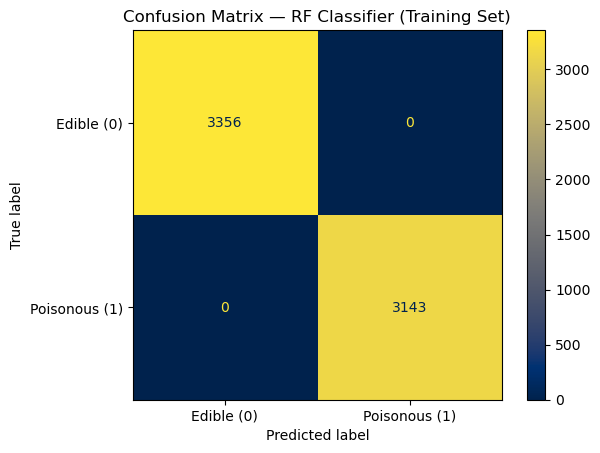

True Negatives (Edible correctly classified): 3356
False Positives (Edible predicted as Poisonous): 0
False Negatives (Poisonous predicted as Edible): 0
True Positives (Poisonous correctly classified): 3143


In [22]:
# Random Forest Classifier
trees_in_forest = [250, 500, 1000, 1500, 2000]
cv_scores_rf = {} # Empty dictionary to fill in with the cv scores

# Cross-Validation to determine the best number of trees in the RandomForest Classifier
for n in trees_in_forest:
    RForest_clf = RandomForestClassifier(n_estimators = n, random_state = 0, bootstrap = False) # Defining the model
    scores_train_rf = cross_val_score(RForest_clf, X_train_e, y_train_e, cv = 5) # Scoring the individual cv folds (5)
    cv_scores_rf[n] = scores_train_rf.mean() # Taking the mean score of each fold
    print(f'Accuracy scores for model training on {n} trees Random Forest Classifier:', scores_train_rf.round(4)) # Rounding up the scores to 4 decimals
    print(f'Mean accuracy score model training on {n} trees:', scores_train_rf.mean().round(4)) # Rounding up the scores to 4 decimals

best_n = max(cv_scores_rf, key=cv_scores_rf.get) # Finding the highest cv score using max
print(f"\nBest number of trees from CV: {best_n}")

# Train the classifier on the entire training set
RForest_clf.fit(X_train_e, y_train_e)

# Make predictions on the training set
y_train_pred = RForest_clf.predict(X_train_e)

# Compute the confusion matrix
cm_train = confusion_matrix(y_train_e, y_train_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=["Edible (0)", "Poisonous (1)"])
disp.plot(cmap="cividis")
plt.title("Confusion Matrix — RF Classifier (Training Set)")
plt.show()

# Print numeric values
tn, fp, fn, tp = cm_train.ravel()
print(f"True Negatives (Edible correctly classified): {tn}")
print(f"False Positives (Edible predicted as Poisonous): {fp}")
print(f"False Negatives (Poisonous predicted as Edible): {fn}")
print(f"True Positives (Poisonous correctly classified): {tp}")


Top 10 important feature categories:
odor_n                        0.136039
odor_f                        0.073062
gill-size_n                   0.067968
gill-size_b                   0.066386
stalk-surface-above-ring_k    0.049725
spore-print-color_h           0.044957
gill-color_b                  0.040601
stalk-surface-below-ring_k    0.039493
ring-type_p                   0.031987
bruises_f                     0.026871
dtype: float64


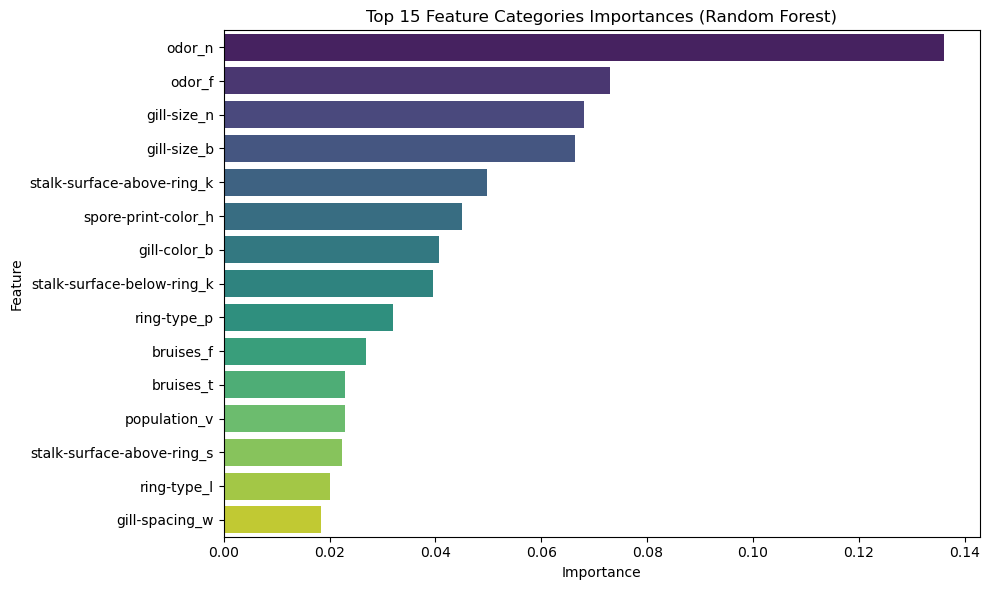

In [23]:
# Get feature importances
importances = pd.Series(RForest_clf.feature_importances_, index=X_train_e.columns)

# Sort descending
importances = importances.sort_values(ascending=False)

# Display top features
print("\nTop 10 important feature categories:")
print(importances.head(10))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(15), y=importances.head(15).index, palette="viridis")
plt.title("Top 15 Feature Categories Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Top 10 selected feature categories: ['odor_n', 'odor_f', 'gill-size_n', 'gill-size_b', 'stalk-surface-above-ring_k', 'spore-print-color_h', 'gill-color_b', 'stalk-surface-below-ring_k', 'ring-type_p', 'bruises_f']
Accuracy scores (top 10 features, 250 trees): [0.9762 0.9777 0.98   0.98   0.98  ]
Mean accuracy (top 10 features, 250 trees): 0.9788
Accuracy scores (top 10 features, 500 trees): [0.9762 0.9777 0.98   0.98   0.98  ]
Mean accuracy (top 10 features, 500 trees): 0.9788
Accuracy scores (top 10 features, 1000 trees): [0.9762 0.9777 0.98   0.98   0.98  ]
Mean accuracy (top 10 features, 1000 trees): 0.9788
Accuracy scores (top 10 features, 1500 trees): [0.9762 0.9777 0.98   0.98   0.98  ]
Mean accuracy (top 10 features, 1500 trees): 0.9788
Accuracy scores (top 10 features, 2000 trees): [0.9762 0.9777 0.98   0.98   0.98  ]
Mean accuracy (top 10 features, 2000 trees): 0.9788

Best number of trees (top 10 features): 250

Test set accuracy (top 10 features): 0.9766


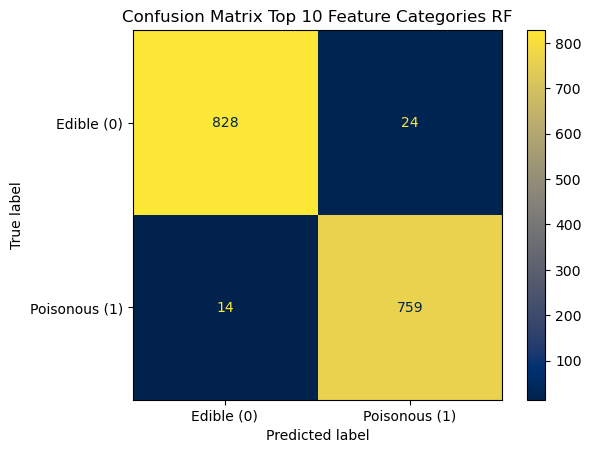

True Negatives (Edible correctly classified): 828
False Positives (Edible predicted as Poisonous): 24
False Negatives (Poisonous predicted as Edible): 14
True Positives (Poisonous correctly classified): 759


In [24]:
# Get top 10 feature categories
top10_feature_cats = importances.head(10).index.tolist()
print("Top 10 selected feature categories:", top10_feature_cats)

# Subset training and test data to top 10
X_train_top10 = X_train_e[top10_feature_cats]
X_test_top10 = X_test_e[top10_feature_cats]

# Re-run the Random Forest CV loop with reduced feature set
trees_in_forest = [250, 500, 1000, 1500, 2000]
cv_scores_rf_top10 = {}

for n in trees_in_forest:
    RForest_clf = RandomForestClassifier(
        n_estimators=n,
        random_state=0,
        bootstrap=False
    )
    scores_train_rf = cross_val_score(
        RForest_clf, X_train_top10, y_train_e, cv=5
    )
    cv_scores_rf_top10[n] = scores_train_rf.mean()

    print(f"Accuracy scores (top 10 features, {n} trees): {scores_train_rf.round(4)}")
    print(f"Mean accuracy (top 10 features, {n} trees): {scores_train_rf.mean().round(4)}")

# Pick best number of trees
best_n_top10 = max(cv_scores_rf_top10, key=cv_scores_rf_top10.get)
print(f"\nBest number of trees (top 10 features): {best_n_top10}")

# Train and evaluate final model on top 10 features
RForest_top10 = RandomForestClassifier(
    n_estimators=best_n_top10,
    random_state=0,
    bootstrap=False
)
RForest_top10.fit(X_train_top10, y_train_e)

accuracy_top10 = RForest_top10.score(X_test_top10, y_test_e)
print(f"\nTest set accuracy (top 10 features): {accuracy_top10:.4f}")


# Make predictions on the test set
y_pred_top10 = RForest_top10.predict(X_test_top10)

# Compute the confusion matrix
cm = confusion_matrix(y_test_e, y_pred_top10)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Edible (0)", "Poisonous (1)"])
disp.plot(cmap="cividis")
plt.title("Confusion Matrix Top 10 Feature Categories RF")
plt.show()

# Optional: print the numeric values
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Edible correctly classified): {tn}")
print(f"False Positives (Edible predicted as Poisonous): {fp}")
print(f"False Negatives (Poisonous predicted as Edible): {fn}")
print(f"True Positives (Poisonous correctly classified): {tp}")



Training unsupervised Random Forest on TOP 10 feature categories...
Building unsupervised proximity matrix (top 10)...
Performing PCoA (unsupervised, top 10 features categories)...


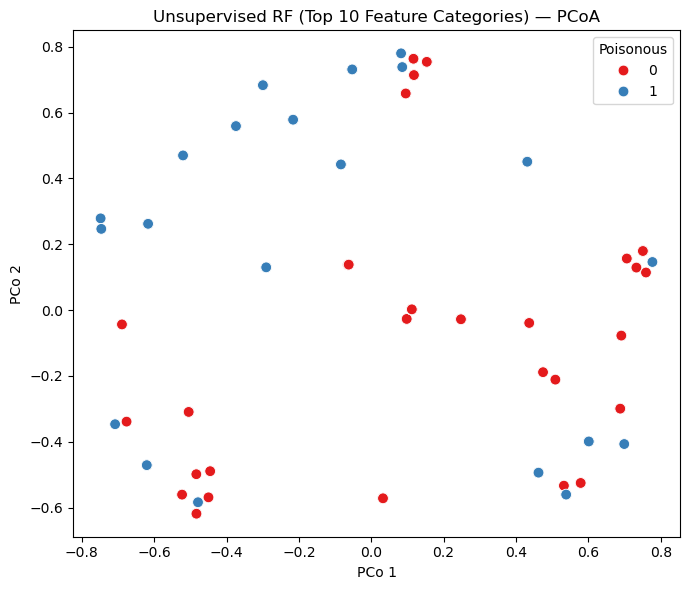

1000

In [25]:
# Run the unsupervised RF again but with only the final top 10 features, look at the difference of the clustering
# Create a reduced dataset with only the top 10 features
X_top10 = m_features_encoded_df[top10_feature_cats]
y_top10 = pd.Series(m_targets_encoded, name="poisonous")

# Subset it again, not only for speed but to also allow for better comparison
rng = np.random.default_rng(seed=0)
subset_idx = rng.choice(X_top10.index, size=1000, replace=False)
X_sub_top10 = X_top10.loc[subset_idx].reset_index(drop=True)
y_sub_top10 = y_top10.loc[subset_idx].reset_index(drop=True)

print("\nTraining unsupervised Random Forest on TOP 10 feature categories...")
# Generate synthetic randomized data
synthetic_top10 = X_sub_top10.apply(np.random.permutation)
synthetic_top10['label'] = 0
real_top10 = X_sub_top10.copy()
real_top10['label'] = 1

combined_top10 = pd.concat([real_top10, synthetic_top10], axis=0).reset_index(drop=True)
y_unsup_top10 = combined_top10['label']
X_unsup_top10 = combined_top10.drop(columns='label')

rf_unsup_top10 = RandomForestClassifier(
    n_estimators=1000,
    max_features='sqrt',
    n_jobs=-1,
    random_state=0
)
rf_unsup_top10.fit(X_unsup_top10, y_unsup_top10)

# Compute proximity matrix
print("Building unsupervised proximity matrix (top 10)...")
leaves_unsup_top10 = rf_unsup_top10.apply(X_sub_top10)
n_samples_top10, n_trees_top10 = leaves_unsup_top10.shape
prox_unsup_top10 = np.zeros((n_samples_top10, n_samples_top10))

for t in range(n_trees_top10):
    leaf_ids = leaves_unsup_top10[:, t]
    for leaf in np.unique(leaf_ids):
        idx = np.where(leaf_ids == leaf)[0]
        prox_unsup_top10[np.ix_(idx, idx)] += 1

prox_unsup_top10 /= n_trees_top10
dist_unsup_top10 = 1 - prox_unsup_top10

# PCoA on the top 10 unsupervised RF
print("Performing PCoA (unsupervised, top 10 features categories)...")
pcoa_unsup_top10 = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
X_pcoa_unsup_top10 = pcoa_unsup_top10.fit_transform(dist_unsup_top10)

plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_pcoa_unsup_top10[:,0],
    y=X_pcoa_unsup_top10[:,1],
    hue=y_sub_top10,
    palette="Set1",
    s=60
)
plt.title("Unsupervised RF (Top 10 Feature Categories) — PCoA")
plt.xlabel("PCo 1")
plt.ylabel("PCo 2")
plt.legend(title="Poisonous")
plt.tight_layout()
plt.show()

# The points seem less compared to the Unsupervised RF with all the features, so check if there are still 1000 data points.
len(X_pcoa_unsup_top10[:,0])

### Concluding figures:

Lastly, visualising the top 10 feature categories. The first figure was created to see the entire devision of the categories in the features which had the top 10 feature categories. These heatmap figures/tables weren't visually appealing nor easy to read, therefore, a second figure barplot was created to easier compare the feature categories (though the information of the distribution in the features was lost). Lastly, tables were made so showcase precise percentages and easy split between edible and poisonoud related features.

['odor_n', 'odor_f', 'gill-size_n', 'gill-size_b', 'stalk-surface-above-ring_k', 'spore-print-color_h', 'gill-color_b', 'stalk-surface-below-ring_k', 'ring-type_p', 'bruises_f']


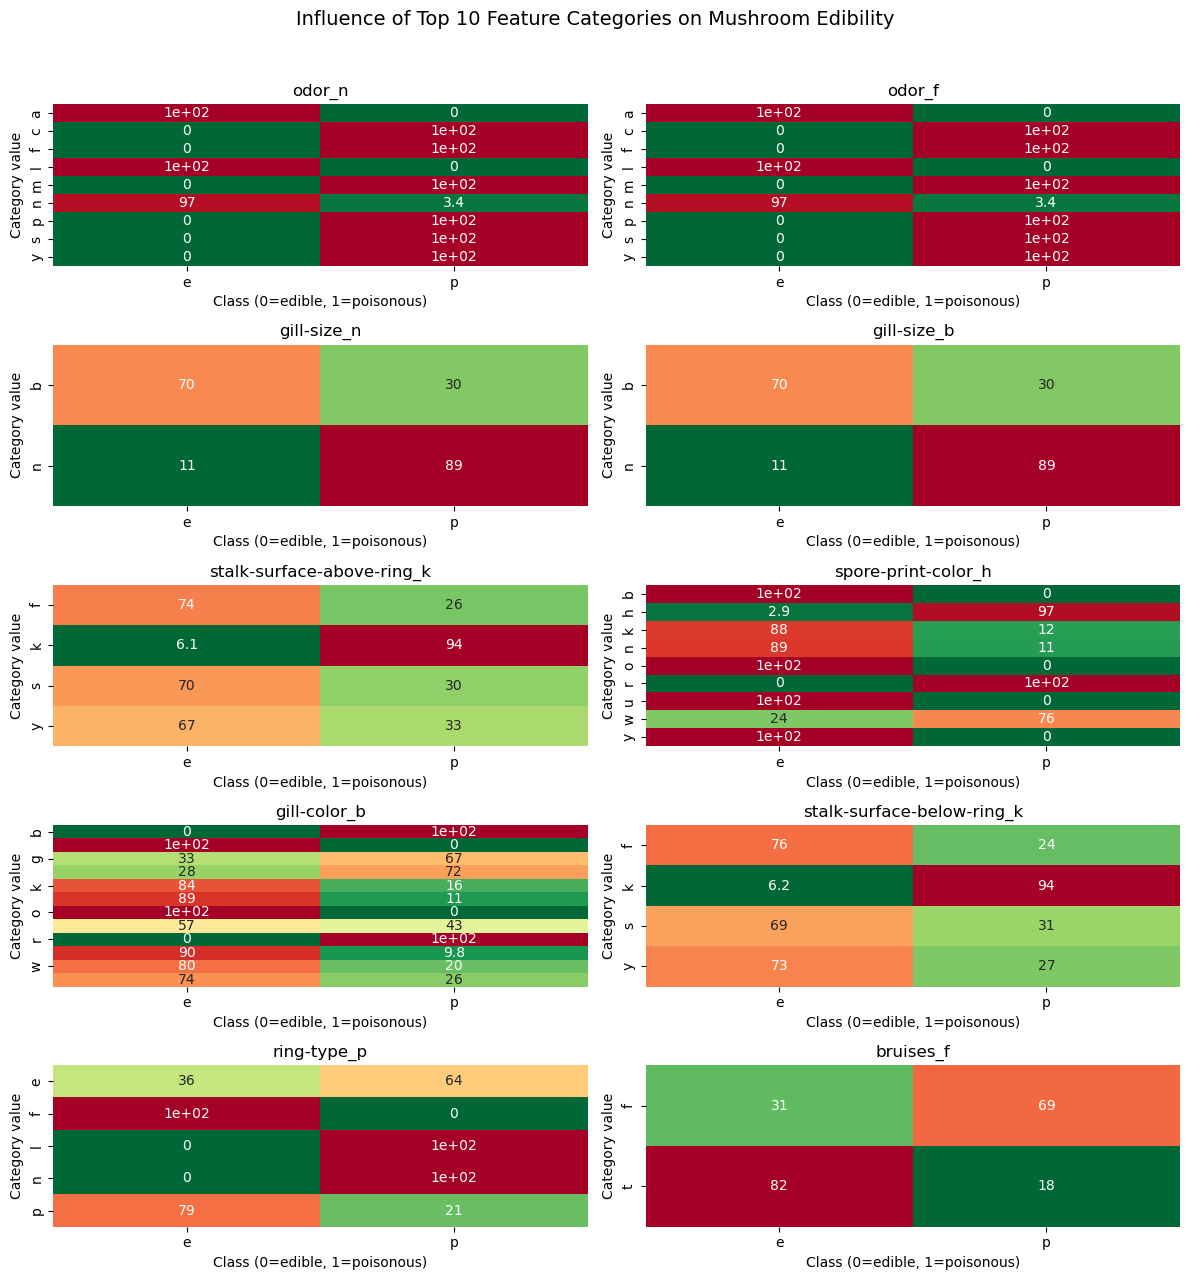

In [26]:
# Influence of the top 10 feature categories on edibility
top10_features = importances.head(10).index.tolist()
print(top10_features)

crosstabs = {}

for feature in top10_features:
    # Extract the original column name from one-hot encoded feature
    orig_col = feature.split('_')[0]
    
    # Only create crosstab if the original column exists
    if orig_col in mushroom_df.columns:
        ct = pd.crosstab(
            mushroom_df[orig_col],
            mushroom_df['poisonous'],
            normalize='index'
        ) * 100
        crosstabs[feature] = ct

# Grid layout 
n_features = len(top10_features)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

# Creating the different subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 2.5))
axes = axes.flatten()

# For loop to create the different heatmap for each feature in the top 10 feature categories
for i, feature in enumerate(top10_features):
    sns.heatmap(
        crosstabs[feature].round(2),
        annot=True,
        cmap="RdYlGn_r",
        cbar=False,
        ax=axes[i]
    )
    axes[i].set_title(feature)
    axes[i].set_xlabel("Class (0=edible, 1=poisonous)")
    axes[i].set_ylabel("Category value")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Influence of Top 10 Feature Categories on Mushroom Edibility", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

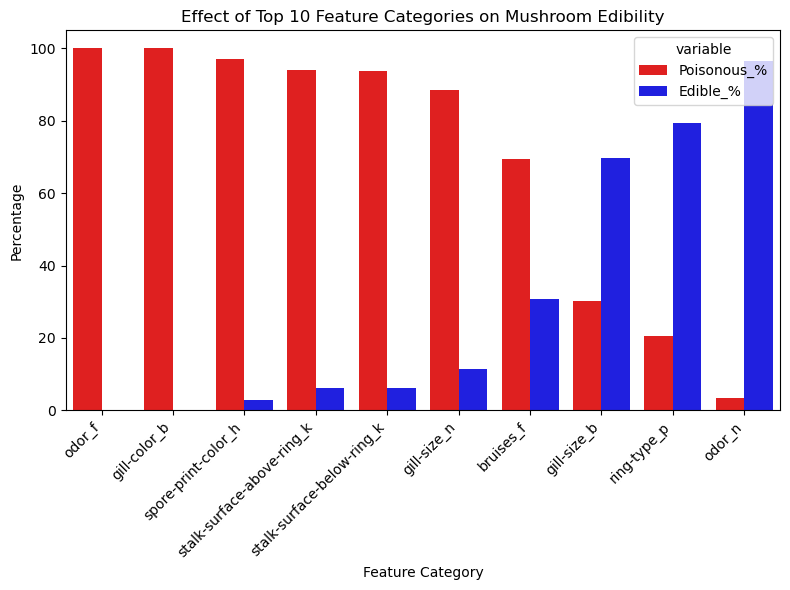


 Features most associated with poisonous mushrooms:


,Feature_Category,Poisonous_%
1,odor_f,100.000000
6,gill-color_b,100.000000
5,spore-print-color_h,97.058824
4,stalk-surface-above-ring_k,93.929174
7,stalk-surface-below-ring_k,93.750000
2,gill-size_n,88.535032
9,bruises_f,69.334457



 Features most associated with edible mushrooms:


,Feature_Category,Edible_%
3,gill-size_b,69.850321
8,ring-type_p,79.435484
0,odor_n,96.598639


In [27]:
# Ensure the same top 10 list from your importances
top10_features = importances.head(10).index.tolist()

results = []

# Loop through top 10 encoded features
for feature in top10_features:
    if feature not in m_features_encoded_df.columns:
        print(f"Skipped {feature} (not in encoded dataframe)")
        continue
    
    # When this feature is present (1), what % of mushrooms are poisonous?
    mask_present = m_features_encoded_df[feature] == 1
    if mask_present.sum() == 0:
        continue
    
    poisonous_mean = np.mean(m_targets_encoded[mask_present]) * 100  # % poisonous
    edible_mean = 100 - poisonous_mean  # for interpretability
    
    results.append({
        "Feature_Category": feature,
        "Poisonous_%": poisonous_mean,
        "Edible_%": edible_mean
    })

# Convert results to DataFrame
importance_effects = pd.DataFrame(results)

# Sort features: more poisonous on top
importance_effects = importance_effects.sort_values("Poisonous_%", ascending=False)

# Visualization
plt.figure(figsize=(8,6))
sns.barplot(data=importance_effects.melt(id_vars="Feature_Category", value_vars=["Poisonous_%", "Edible_%"]),
    x="Feature_Category", y="value", hue="variable", palette=["red", "blue"])
plt.title("Effect of Top 10 Feature Categories on Mushroom Edibility")
plt.ylabel("Percentage")
plt.xlabel("Feature Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Print summary lists
print("\n Features most associated with poisonous mushrooms:")
display(importance_effects.loc[importance_effects["Poisonous_%"] > 50, ["Feature_Category", "Poisonous_%"]])

print("\n Features most associated with edible mushrooms:")
display(importance_effects.loc[importance_effects["Poisonous_%"] <= 50, ["Feature_Category", "Edible_%"]])

### Final Conclusion:

A random forest classifier is a good algorithm to predict this data set of mushroom edibility. Overall, there were significant differences in variance explained per feature (category) and it was fasinating to see the different results. The easiest feature to rember would be odor, if a mushroom has no smell, it is most likely edible, and if it's smell is foul, it is most likely poisonous.